## Airline Passenger Satisfaction
by: Jeremiah Chinyelugo

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_train = pd.read_csv('Datasets//Airline Passenger Satisfaction//train.csv')
df_test = pd.read_csv('Datasets//Airline Passenger Satisfaction//test.csv')

In [3]:
df_train.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


We'll drop the Unnamed: 0 & id columns as they offer no informative value

In [4]:
df_train.drop(['id','Unnamed: 0'], axis = 1, inplace = True)
df_test.drop(['id','Unnamed: 0'], axis = 1, inplace = True)

##### Checking for missing values

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             103904 non-null  object 
 1   Customer Type                      103904 non-null  object 
 2   Age                                103904 non-null  int64  
 3   Type of Travel                     103904 non-null  object 
 4   Class                              103904 non-null  object 
 5   Flight Distance                    103904 non-null  int64  
 6   Inflight wifi service              103904 non-null  int64  
 7   Departure/Arrival time convenient  103904 non-null  int64  
 8   Ease of Online booking             103904 non-null  int64  
 9   Gate location                      103904 non-null  int64  
 10  Food and drink                     103904 non-null  int64  
 11  Online boarding                    1039

### Visualizing the Dataset

In [6]:
num_cols = ['Age', 'Flight Distance', 'Inflight wifi service','Departure/Arrival time convenient', 'Ease of Online booking',
'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 
'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 
'Departure Delay in Minutes', 'Arrival Delay in Minutes']

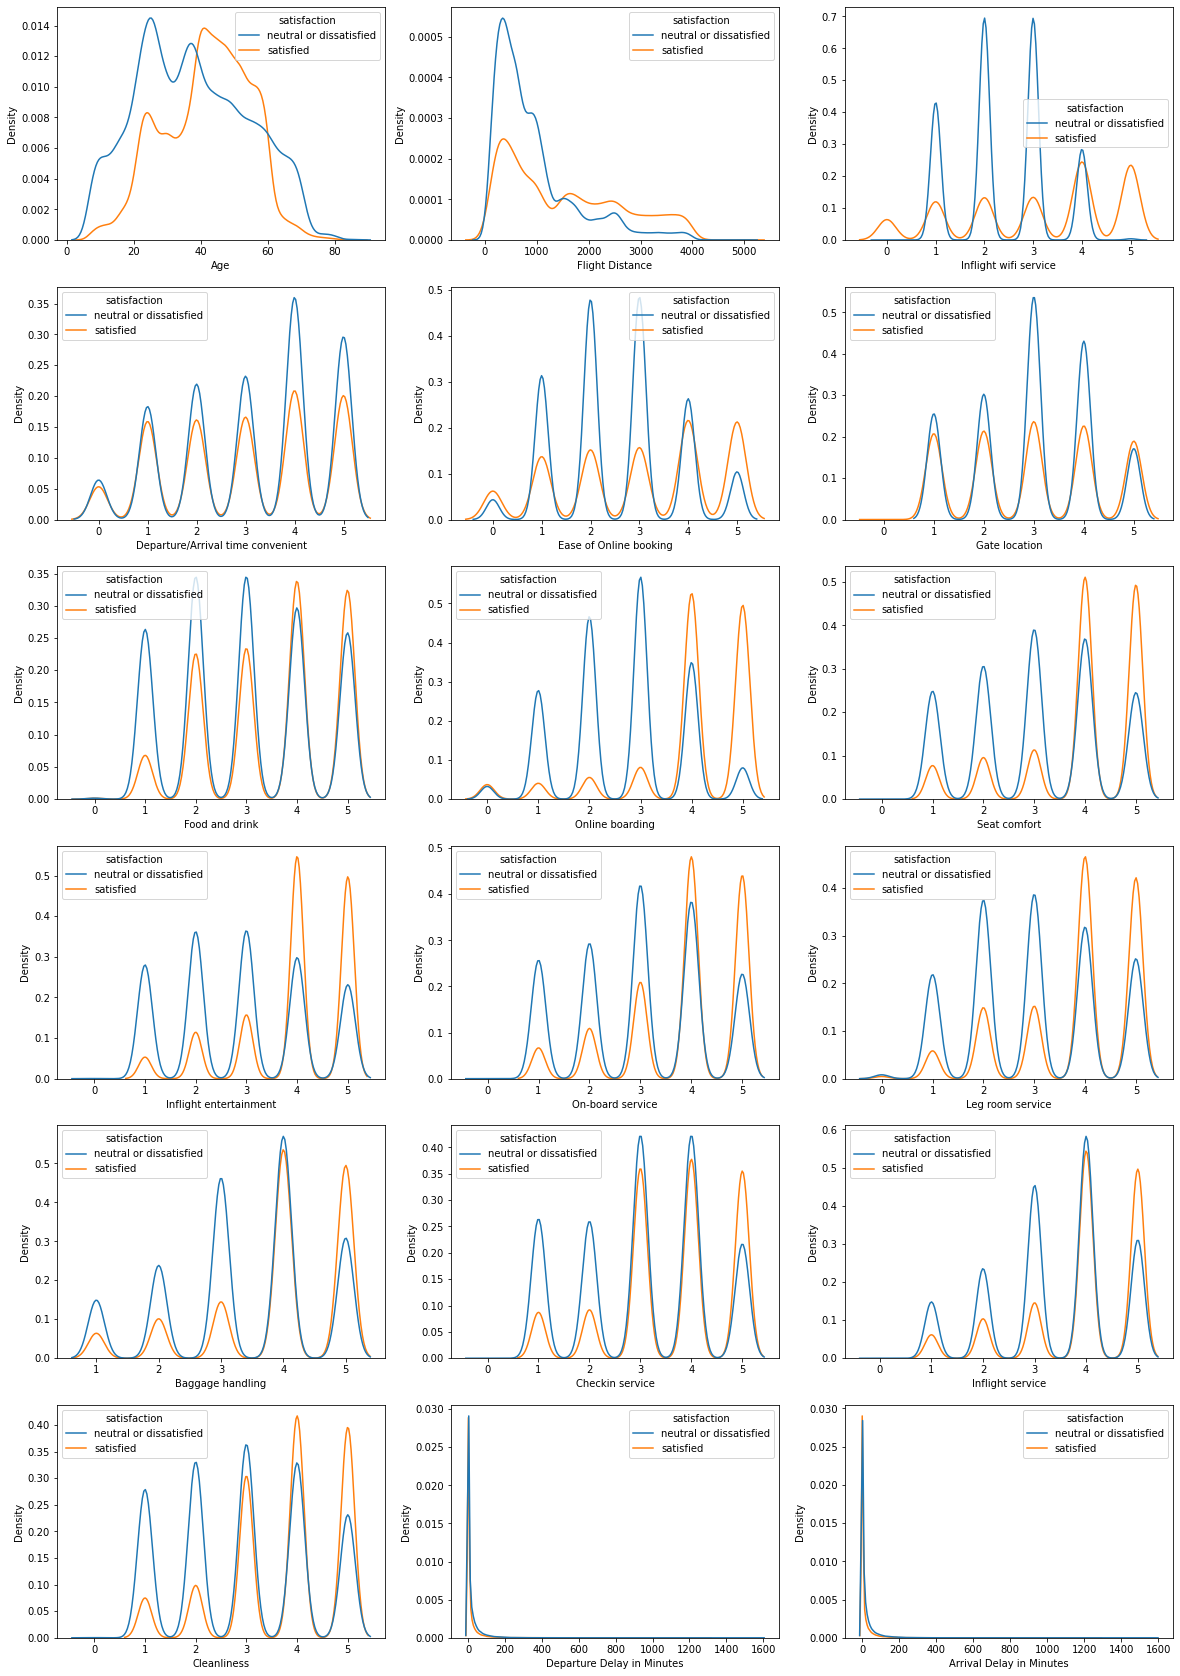

In [7]:
a, b = 0, 0
fig, ax = plt.subplots(6,3, figsize = (20,30))

for col in num_cols:
    sns.kdeplot(data = df_train, x = col, hue = 'satisfaction', ax=ax[a,b])
    b +=1
    if b == 3:
        b = 0
        a +=1

plt.show()

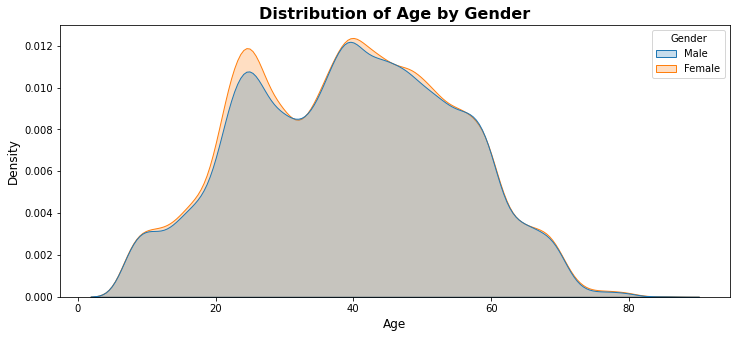

In [8]:
plt.figure(figsize = (12,5))
sns.kdeplot(data = df_train, x = 'Age', hue = 'Gender', shade = True)
plt.xlabel('Age', fontsize = 12)
plt.ylabel('Density', fontsize = 12)
plt.title('Distribution of Age by Gender', fontsize = 16, weight = 'bold')
plt.show()

### Separating the datasets

In [9]:
df_train['satisfaction'].value_counts()

neutral or dissatisfied    58879
satisfied                  45025
Name: satisfaction, dtype: int64

Let's make `satisfied = 1` & `neutral or dissatisfied = 0`

In [10]:
for df in (df_train, df_test):
    df['satisfaction'] = np.where(df['satisfaction'] == 'satisfied', 1, 0)

In [11]:
matrix_corr = df_train.corr()
mask = np.zeros_like(matrix_corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

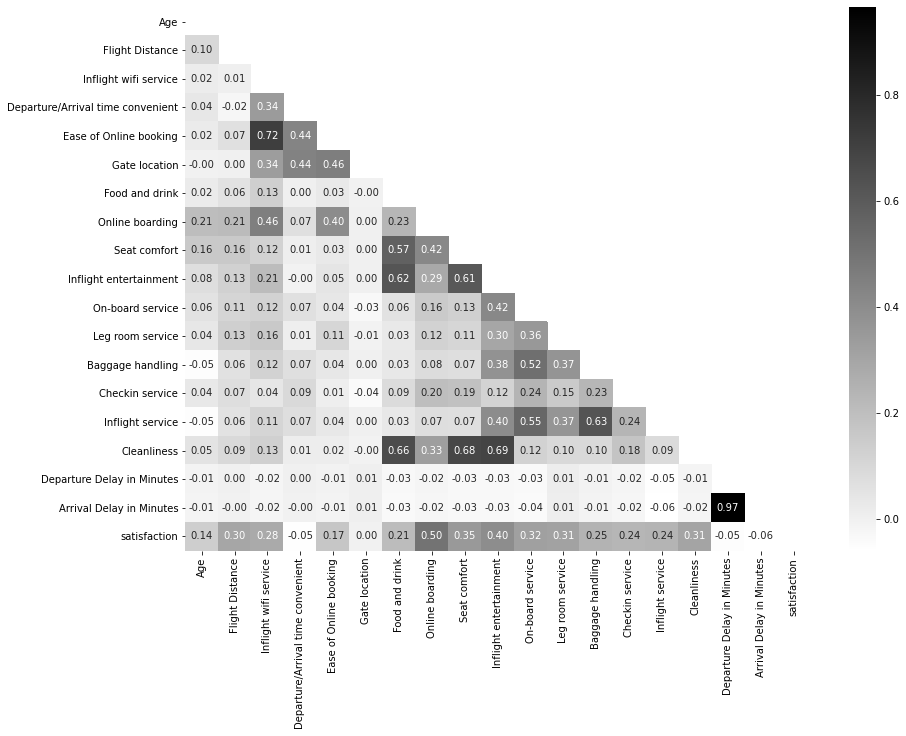

In [12]:
plt.figure(figsize = (14,10))
sns.heatmap(matrix_corr, mask = mask, annot = True, cmap = 'gray_r', fmt = '.2f')
plt.show()

In [13]:
df_train['satisfaction'].value_counts()

0    58879
1    45025
Name: satisfaction, dtype: int64

In [14]:
X_train = df_train.drop('satisfaction', axis = 1) 
y_train = df_train['satisfaction']

X_test = df_test.drop('satisfaction', axis = 1) 
y_test = df_test['satisfaction']

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

In [16]:
num_attribs = X_train.select_dtypes(exclude=object).columns
cat_attribs = X_train.select_dtypes(include=object).columns

In [17]:
# Class to handle dataframe selection

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attrib_names):
        self.attrib_names = attrib_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attrib_names]

In [18]:
num_pipeline = Pipeline([
    ('Select dataframe', DataFrameSelector(num_attribs)),
    ('imputer', SimpleImputer(strategy = 'median'))
])

In [19]:
cat_pipeline = Pipeline([
    ('Select dataframe', DataFrameSelector(cat_attribs)),
    ('cat_encoder', OneHotEncoder(sparse=False))
])

In [20]:
full_pipeline = FeatureUnion(transformer_list = [
    ('numerical', num_pipeline),
    ('categorical', cat_pipeline)
])

In [21]:
X_train_scaled = full_pipeline.fit_transform(X_train)
X_test_scaled = full_pipeline.transform(X_test)

### Importing the Models

In [22]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score

In [23]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

In [24]:
rnd_clf = RandomForestClassifier(random_state = 42)
grd_clf = GradientBoostingClassifier(random_state = 42)
svc_clf = SVC(random_state = 42)
lin_svc_clf = LinearSVC(random_state = 42, max_iter = 100_000)
log_clf = LogisticRegression(random_state = 42, max_iter = 100_000)
sgd_clf = SGDClassifier(random_state = 42, max_iter = 100_000)
knn_clf = KNeighborsClassifier(n_neighbors = 5, weights = 'distance')

In [25]:
models = [rnd_clf, grd_clf, lin_svc_clf, log_clf, sgd_clf, knn_clf]

Having tried all models previously, the randomforest and gradient boosting ensembles performed better

In [26]:
models = [rnd_clf, grd_clf]

In [27]:
for model in models:
    model.fit(X_train_scaled, y_train)
    pred = cross_val_predict(model, X_train_scaled, y_train, cv = 3)
    score = f1_score(y_train, pred)
    pr_score = precision_score(y_train, pred)
    re_score = recall_score(y_train, pred)
    score2 = roc_auc_score(y_train, pred)
    print(f'{model.__class__.__name__}: {score:.4f}')
    print(f'precision score: {pr_score:.4f}')
    print(f'recall score: {re_score:.4f}')
    print(f'ROC score: {score2:.4f}\n')

RandomForestClassifier: 0.9559
precision score: 0.9713
recall score: 0.9410
ROC score: 0.9599

GradientBoostingClassifier: 0.9323
precision score: 0.9451
recall score: 0.9199
ROC score: 0.9395



The RandomForestClassifier had the better score, therefore that's what i'll be using.

### GridSearchCV

In [28]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [29]:
param_grid = {'max_depth':[28,30,32,33], 'min_samples_split':[3,4,5]}

In [30]:
grid_search = GridSearchCV(rnd_clf, param_grid, cv = 3, scoring = 'f1')
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [28, 30, 32, 33],
                         'min_samples_split': [3, 4, 5]},
             scoring='f1')

In [31]:
grid_search.best_params_

{'max_depth': 30, 'min_samples_split': 4}

In [32]:
grid_search.best_score_

0.955902202282427

No difference from the default parameters. Therefore we'll stick to the default parameters going forward

### Precision Recall Curve

In [33]:
from sklearn.metrics import precision_recall_curve, roc_curve, confusion_matrix

In [34]:
proba = cross_val_predict(rnd_clf, X_train_scaled, y_train, cv = 3, method = 'predict_proba')

In [35]:
precisions, recalls, thresholds = precision_recall_curve(y_train, proba[:,1])

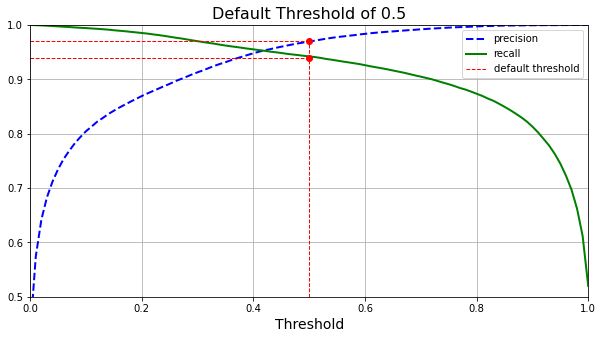

In [36]:
plt.figure(figsize=(10,5))
plt.plot(thresholds, precisions[:-1], 'b--', label = 'precision', lw = 2)
plt.plot(thresholds, recalls[:-1], 'g', label = 'recall', lw = 2)
plt.plot([0.5,0.5],[0.5,.97], 'r--', lw = 1, label = 'default threshold')
plt.plot([0,0.5],[0.94,0.94], 'r--', lw = 1)
plt.plot([0,0.5],[0.97,0.97], 'r--', lw = 1)
plt.plot([0.5],[0.94], 'o', color = 'red')
plt.plot([0.5],[0.97], 'o', color = 'red')
plt.axis([0,1,0.5,1.0])
plt.xlabel('Threshold', fontsize = 14)
plt.title('Default Threshold of 0.5', fontsize = 16)
plt.grid()
plt.legend()
plt.show()

The default threshold of 0.5 gave us a model with precision of 97% and recall of 94%. Let's take a look at the confusion matrix

In [37]:
conf_matrix_pred = cross_val_predict(rnd_clf, X_train_scaled, y_train, cv = 3)

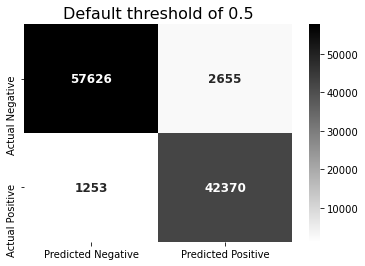

In [38]:
conf_matrix = confusion_matrix(conf_matrix_pred, y_train)
sns.heatmap(conf_matrix, annot = True, fmt = '.0f', cmap = 'gray_r', xticklabels = ['Predicted Negative','Predicted Positive'],
           yticklabels = ['Actual Negative','Actual Positive'], annot_kws = {'weight':'bold', 'size':12})
plt.title('Default threshold of 0.5', fontsize = 16)
plt.show()

Depending on the business case, we'll have to adjust the threshold for our precision/recall. If our business aim is to accurately predict people that will be unsatisfied with the trip then we increase our precision, but if we intend to indetify EVERYONE that might be unsatisfied with the trip, then we increase our recall. I'll demonstrate both cases below 

##### Increasing Recall

In [39]:
thresholds[np.argmin(recalls >= 0.99)]

0.16

In [40]:
precisions[np.argmin(recalls >= 0.99)]

0.8482292460015233

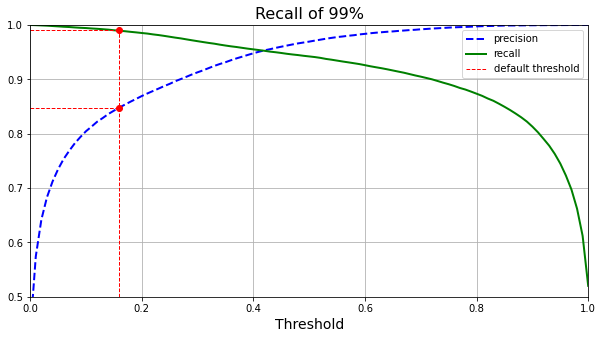

In [41]:
plt.figure(figsize=(10,5))
plt.plot(thresholds, precisions[:-1], 'b--', label = 'precision', lw = 2)
plt.plot(thresholds, recalls[:-1], 'g', label = 'recall', lw = 2)
plt.plot([0.16,0.16],[0.5,.99], 'r--', lw = 1, label = 'default threshold')
plt.plot([0,0.16],[0.99,0.99], 'r--', lw = 1)
plt.plot([0,0.16],[0.8482,0.8482], 'r--', lw = 1)
plt.plot([0.16],[0.99], 'o', color = 'red')
plt.plot([0.16],[0.8482], 'o', color = 'red')
plt.axis([0,1,0.5,1.0])
plt.xlabel('Threshold', fontsize = 14)
plt.title('Recall of 99%', fontsize = 16)
plt.grid()
plt.legend()
plt.show()

To increase our recall to 99%, we'll have to decrease our threshold from 0.5 to 0.16

In [42]:
proba = cross_val_predict(rnd_clf, X_train_scaled, y_train, cv = 3, method = 'predict_proba')
conf_matrix_pred = np.where(proba[:,1] >= 0.16, 1, 0)

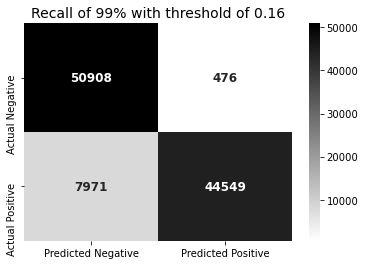

In [43]:
conf_matrix = confusion_matrix(conf_matrix_pred, y_train)
sns.heatmap(conf_matrix, annot = True, fmt = '.0f', cmap = 'gray_r', xticklabels = ['Predicted Negative','Predicted Positive'],
           yticklabels = ['Actual Negative','Actual Positive'], annot_kws = {'weight':'bold', 'size':12})
plt.title('Recall of 99% with threshold of 0.16', fontsize = 14)
plt.show()

##### Increasing Precision

In [44]:
thresholds[np.argmax(precisions >= 0.99)] 

0.68

In [45]:
recalls[np.argmax(precisions >= 0.99)]

0.9096724042198778

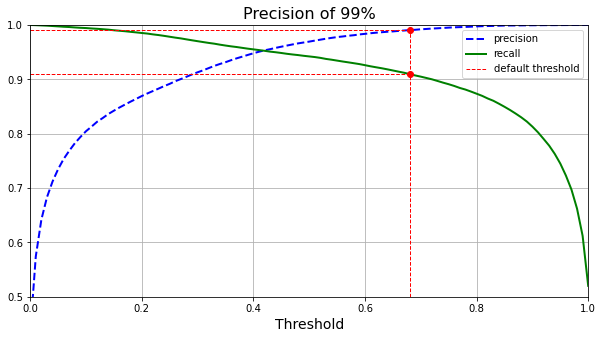

In [46]:
plt.figure(figsize=(10,5))
plt.plot(thresholds, precisions[:-1], 'b--', label = 'precision', lw = 2)
plt.plot(thresholds, recalls[:-1], 'g', label = 'recall', lw = 2)
plt.plot([0.68,0.68],[0.5,.99], 'r--', lw = 1, label = 'default threshold')
plt.plot([0,0.68],[0.9096,0.9096], 'r--', lw = 1)
plt.plot([0,0.68],[0.99,0.99], 'r--', lw = 1)
plt.plot([0.68],[0.9096], 'o', color = 'red')
plt.plot([0.68],[0.99], 'o', color = 'red')
plt.axis([0,1,0.5,1.0])
plt.xlabel('Threshold', fontsize = 14)
plt.title('Precision of 99%', fontsize = 16)
plt.grid()
plt.legend()
plt.show()

To increase our precision to 99%, we'll increase our threshold from 0.5 to 0.68

In [47]:
proba = cross_val_predict(rnd_clf, X_train_scaled, y_train, cv = 3, method = 'predict_proba')
conf_matrix_pred = np.where(proba[:,1] >= 0.68, 1, 0)

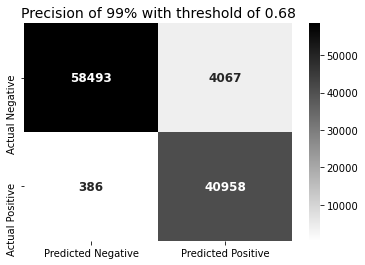

In [48]:
conf_matrix = confusion_matrix(conf_matrix_pred, y_train)
sns.heatmap(conf_matrix, annot = True, fmt = '.0f', cmap = 'gray_r', xticklabels = ['Predicted Negative','Predicted Positive'],
           yticklabels = ['Actual Negative','Actual Positive'], annot_kws = {'weight':'bold', 'size':12})
plt.title('Precision of 99% with threshold of 0.68', fontsize = 14)
plt.show()

These precision/recall trade offs depend on the business objective as stated earlier. The aim of this particular task is to predict what factors contribute to customer satisfaction, hence we'll increase our precision.

### ROC Curve

In [49]:
proba = cross_val_predict(rnd_clf, X_train_scaled, y_train, cv = 3, method = 'predict_proba')

In [50]:
fpr, tpr, thresholds = roc_curve(y_train, proba[:,1])

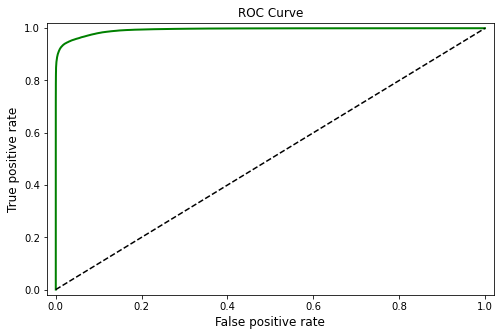

In [51]:
plt.figure(figsize = (8,5))
plt.plot(fpr, tpr, 'g', lw = 2)
plt.plot([0,1],[0,1], 'k--')
plt.axis([-0.02,1.02,-0.02,1.02])
plt.xlabel('False positive rate', fontsize = 12)
plt.ylabel('True positive rate', fontsize = 12)
plt.title('ROC Curve')
plt.show()

### Evaluating the model on the Test set (Default threshold)

In [52]:
rnd_clf = RandomForestClassifier(random_state = 42)

In [53]:
rnd_clf.fit(X_train_scaled, y_train)
pred = rnd_clf.predict(X_test_scaled)
score = f1_score(y_test, pred)
pr_score = precision_score(y_test, pred)
re_score = recall_score(y_test, pred)
score2 = roc_auc_score(y_test, pred)
print('Random Forest Classifier')
print(f'f1 score: {score:.4f}')
print(f'precision score: {pr_score:.4f}')
print(f'recall score: {re_score:.4f}')
print(f'ROC score: {score2:.4f}\n')

Random Forest Classifier
f1 score: 0.9579
precision score: 0.9732
recall score: 0.9430
ROC score: 0.9613



#### 99% Precision with Threshold of 0.68

In [54]:
rnd_clf.fit(X_train_scaled, y_train)
pred_proba = rnd_clf.predict_proba(X_test_scaled)
pred = np.where(pred_proba[:,1] >= 0.68, 1, 0)
score = f1_score(y_test, pred)
pr_score = precision_score(y_test, pred)
re_score = recall_score(y_test, pred)
score2 = roc_auc_score(y_test, pred)
print('Random Forest Classifier')
print(f'f1 score: {score:.4f}')
print(f'precision score: {pr_score:.4f}')
print(f'recall score: {re_score:.4f}')
print(f'ROC score: {score2:.4f}\n')

Random Forest Classifier
f1 score: 0.9521
precision score: 0.9898
recall score: 0.9171
ROC score: 0.9549



## The End